<a href="https://colab.research.google.com/github/haalcala/NYP-SDAI/blob/master/ITI105/project/Fraud_detection_harold_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>


# Fraud detection using kNN

In [1]:
import requests
import io
import os

try:
    os.mkdir("./tmp")
except:
    pass

external_files = [
  {
      "url":"https://raw.githubusercontent.com/haalcala/NYP-SDAI/master/ITI105/project/ds_util.py",
      "local_file":"ds_util.py"
  },
  {
      "url":"https://raw.githubusercontent.com/haalcala/NYP-SDAI/master/ITI105/project/files/bs140513_032310.csv",
      "local_file":"bs140513_032310.csv"
  },
]

for ext_file in external_files:
  req = requests.get(ext_file["url"])

  print(ext_file["local_file"], len(req.content))

  f = open("./tmp/" + ext_file["local_file"],"wb")

  f.write(req.content)

ds_util.py 1901
bs140513_032310.csv 48391391



## load and prepare data


In [2]:
import tmp.ds_util as util

ds_util = util.DSUtil()
ds_util.load_csv("./tmp/bs140513_032310.csv")

# analyse data composition
ds_util.blow_my_mind()

args: {}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB
None
unique step    180
dtype: int64
unique customer    4112
dtype: int64
unique age    8
dtype: int64
unique gender    4
dtype: int64
unique zipcodeOri    1
dtype: int64
unique merchant    50
dtype: int64
unique zipMerchant    1
dtype: int64
unique category    15
dtype: int64
unique amount    23767


### drop columns not needed for calculations and get dummy variables

In [3]:
ds_util.drop_columns(["customer", "zipMerchant", "zipcodeOri"])

df = ds_util.get_dummies()

df

,step,amount,fraud,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0,4.55,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,39.68,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,26.89,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,17.25,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,35.72,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,179,20.53,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
594639,179,50.73,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
594640,179,22.44,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594641,179,14.46,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## kNN Stuffs                                                     


### Training


In [14]:
#We need to import the k-NN Classifier from skleart.neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
import numpy as np

target_column = "fraud"

#Set the target column as our label (target value to be predicted)
YTrain = df[target_column]

#Remove the target column from our input variables
XTrain = df.drop(target_column, axis=1)

sm = SMOTE(random_state=12)
x_res, y_res = sm.fit_sample(XTrain, YTrain)
print(YTrain.value_counts(), np.bincount(y_res))


#Create a k-NN Classifier
classifier = KNeighborsClassifier(n_neighbors=1)

# X_train, X_test, y_train, y_test = train_test_split(XTrain, YTrain, train_size=0.8, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, train_size=0.8, shuffle=True, random_state=42)

print("-------------------------------------------------")
print("X_train:",X_train.info())
print("-------------------------------------------------")
print("X_test:",X_test.info())
print("-------------------------------------------------")
print("y_train:",y_train)
print("-------------------------------------------------")
print("y_test:",y_test)
print("-------------------------------------------------")

def train_fn():
    #Train the classifier using our training data
    classifier.fit(X_train, y_train)

ds_util.activity_wrapper("Training", train_fn)

0    587443
1      7200
Name: fraud, dtype: int64 [587443 587443]
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 939908 entries, 401825 to 121958
Data columns (total 79 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   step                              939908 non-null  int64  
 1   amount                            939908 non-null  float64
 2   age_'0'                           939908 non-null  uint8  
 3   age_'1'                           939908 non-null  uint8  
 4   age_'2'                           939908 non-null  uint8  
 5   age_'3'                           939908 non-null  uint8  
 6   age_'4'                           939908 non-null  uint8  
 7   age_'5'                           939908 non-null  uint8  
 8   age_'6'                           939908 non-null  uint8  
 9   age_'U'                           939908 non-null  uint8  


In [8]:
x_res

,step,amount,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0,4.550000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,39.680000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,26.890000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,17.250000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,35.720000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174881,35,3256.547631,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1174882,166,403.220133,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174883,63,509.186641,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174884,114,285.456117,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y_res

0          0
1          0
2          0
3          0
4          0
          ..
1174881    1
1174882    1
1174883    1
1174884    1
1174885    1
Name: fraud, Length: 1174886, dtype: int64

In [10]:
y_res[y_res == 0]

0         0
1         0
2         0
3         0
4         0
         ..
594638    0
594639    0
594640    0
594641    0
594642    0
Name: fraud, Length: 587443, dtype: int64

In [11]:
y_res[y_res == 1]

88         1
89         1
434        1
435        1
553        1
          ..
1174881    1
1174882    1
1174883    1
1174884    1
1174885    1
Name: fraud, Length: 587443, dtype: int64

### Testing


Testing ...
Doing some manual testing ...
Testing fraud entry to be fraud ... passed
Testing not fraud entry to be not fraud ... passed
Doing some manual testing ... done. 0.001954 seconds
Doing some testing (the datascience way) ...
accuracy_score: 0.9856965332924784
cross_val_score: [0.98322072 0.98339307 0.98331003]
confusion_matrix [[454216  15602]
 [    87 470003]]
recall_score: 0.9667913958171036
precision_score: 0.9998084978527546
f1_score: 0.9830227859771611
classification_report:               precision    recall  f1-score   support

           0       1.00      0.97      0.98    469818
           1       0.97      1.00      0.98    470090

    accuracy                           0.98    939908
   macro avg       0.98      0.98      0.98    939908
weighted avg       0.98      0.98      0.98    939908

[0 1 1 ... 0 1 0]
Doing some testing (the datascience way) ... done. 288.370456 seconds


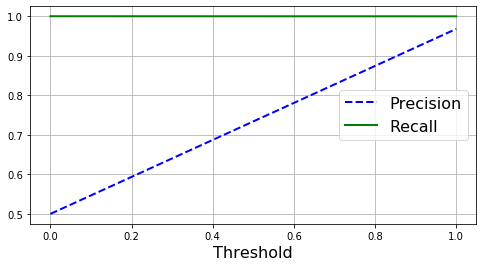

Testing ... done. 288.535618 seconds
Test result: 2/2 done. passed: 2, failed: 0.
All done.


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the first fraud row that we will use for testing (this is not recommended!)
XTest_fraud = df.loc[df.fraud==1].drop(target_column, axis=1).iloc[0].values

# Get the first not fraud row that we will use for testing (this is not recommended!)
XTest_not_fraud = df.loc[df.fraud==0].drop(target_column, axis=1).iloc[0].values

# XTest = pd.DataFrame([
#     # this should give value 1 result
#     XTest_fraud,
#     # this should give value 0 result
#     XTest_not_fraud
# ])

# for index, row in XTest.iterrows():
#     print(classifier.predict(row.values.reshape(1, -1)))

total_test_count = 2
tests_count_done = 0
tests_passed = 0
tests_failed = 0

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                                           

def test_fn():
#     global tests_count_done, tests_passed, tests_failed
    
    def manual_test_fn():
        global tests_count_done, tests_passed, tests_failed

        tests_count_done = tests_count_done+1
        if classifier.predict(XTest_fraud.reshape(1,-1))[0] == 1:
            tests_passed = tests_passed+1
            print("Testing fraud entry to be fraud ... passed")
        else:
            tests_failed = tests_failed+1
            print("Testing fraud entry to be fraud ... failed")

        tests_count_done = tests_count_done+1
        if classifier.predict(XTest_not_fraud.reshape(1,-1))[0] == 0:
            tests_passed = tests_passed+1
            print("Testing not fraud entry to be not fraud ... passed")
        else:
            tests_failed = tests_failed+1
            print("Testing not fraud entry to be not fraud ... failed")
            
    ds_util.activity_wrapper("Doing some manual testing", manual_test_fn)

    def ds_test():
        global y_scores
        
        y_pred = classifier.predict(X_test) 

        print("accuracy_score:", accuracy_score(y_test, y_pred))

        print("cross_val_score:", cross_val_score(classifier, X_train, y_train, cv=3, scoring="accuracy"))

        y_train_pred = cross_val_predict(classifier, X_train, y_train, cv=3)

        print("confusion_matrix", confusion_matrix(y_train, y_train_pred))

    #     y_train_perfect_predictions = y_train

    #     print("confusion_matrix", confusion_matrix(y_train, y_train_perfect_predictions))

        print("recall_score:", recall_score(y_train, y_train_pred, pos_label=0))
        print("precision_score:", precision_score(y_train, y_train_pred, pos_label=0))
        print("f1_score:",f1_score(y_train, y_train_pred, pos_label=0))

        print("classification_report:", classification_report(y_train, y_train_pred))

        y_scores = y_train_pred

        print(y_scores)
        
    ds_util.activity_wrapper("Doing some testing (the datascience way)", ds_test)
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    plt.figure(figsize=(8, 4))                      
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    
    plt.show()

ds_util.activity_wrapper("Testing", test_fn)
     
print(f"Test result: {tests_count_done}/{total_test_count} done. passed: {tests_passed}, failed: {tests_failed}.")

print("All done.")